In [1]:
import os, glob
import librosa, numpy as np
import pandas as pd


In [2]:
from pathlib import Path

BASE = Path("../data/raw/audio_depression")   # <-- matches the structure above
print("Exists:", BASE.exists())
print("Subfolders:", [p.name for p in BASE.iterdir() if p.is_dir()])


Exists: True
Subfolders: ['depression1', 'depression2', 'normal1', 'normal2']


In [3]:
from pathlib import Path

classes = ["depression1","depression2","normal1","normal2"]
for c in classes:
    n = len(list((BASE / c).glob("*.wav")))
    print(f"{c}: {n} files")


depression1: 200 files
depression2: 200 files
normal1: 200 files
normal2: 200 files


In [6]:
# Step 4: Load one sample audio file and inspect its properties

import librosa

# Let's pick one file path manually from our dataset
sample_path = BASE / "depression1" / "OAF_back_sad.wav"   # replace "sample1.wav" with any real file name you have

# Load the audio file
# y → waveform (array of amplitude values)
# sr → sample rate (how many audio samples per second)
y, sr = librosa.load(sample_path, sr=16000)  # we set 16k sample rate (common for speech)

# Print some info about the audio
print(f"Sample rate: {sr} Hz")          # how many samples per second
print(f"Duration: {len(y)/sr:.2f} sec") # convert sample count to time
print(f"Waveform shape: {y.shape}")     # number of data points


Sample rate: 16000 Hz
Duration: 2.56 sec
Waveform shape: (40999,)


📘 Explanation (read slowly)

librosa.load() → reads your .wav file and converts it to a NumPy array.

y = the sound wave — values between -1.0 and +1.0 representing loudness at each time step.

sr = sampling rate — number of audio samples captured per second.

len(y)/sr = total duration (in seconds).

👉 This confirms your file loads correctly and audio data is readable

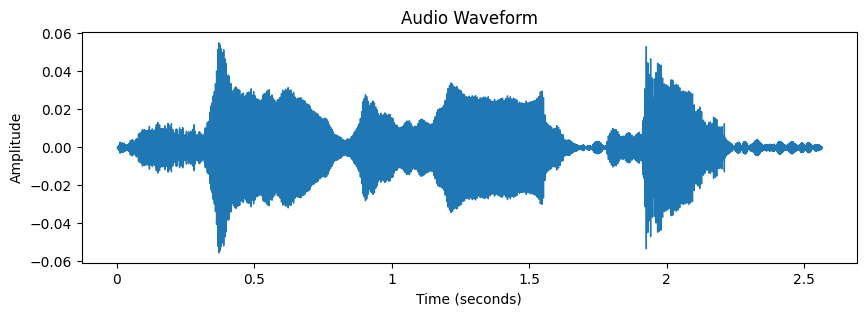

In [7]:
# Step 5: visualize the waveform of the sample audio
import librosa.display
import matplotlib.pyplot as plt

# create a figure
plt.figure(figsize=(10, 3))

# draw the waveform
librosa.display.waveshow(y, sr=sr)

# add title and labels
plt.title("Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")

# show the plot
plt.show()


📘 Explanation (line by line)

librosa.display.waveshow() → takes your waveform array y and draws it over time.

X-axis: time (in seconds)

Y-axis: amplitude (-1 to +1 = how loud the sound is).

High peaks → louder sound.

Flat/quiet sections → silence or soft voice.

In [8]:
# Step 6: Extract MFCC (Mel-Frequency Cepstral Coefficients) features from the audio

import numpy as np

# Extract 13 MFCC features from the audio signal
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Print the shape to understand how many features and frames we got
print("MFCC shape:", mfcc.shape)

# To make it easier for ML models, we'll take the mean of each coefficient across all time frames
mfcc_mean = np.mean(mfcc, axis=1)

print("MFCC feature vector shape:", mfcc_mean.shape)
print("MFCC mean values:\n", mfcc_mean)


MFCC shape: (13, 81)
MFCC feature vector shape: (13,)
MFCC mean values:
 [-5.3064453e+02  7.8489700e+01  1.8757963e+01  9.7518940e+00
  2.1164202e+01 -4.5302734e-01 -1.6253120e+01 -1.1114124e+01
 -7.4364471e-01 -5.5895600e+00  3.4904721e+00 -1.9702674e+00
  1.3371092e+01]


📘 Explanation (line by line):

librosa.feature.mfcc() → extracts MFCCs (small sets of numbers that describe the sound’s frequency pattern).

By default, we’re extracting 13 coefficients — these describe how tone, pitch, and vocal energy change over time.

mfcc.shape → (13, T) → 13 features for every small frame of the audio.

np.mean(..., axis=1) → we take the average of each MFCC over time → gives one 13-length vector per file.

👉 This “mean MFCC vector” is like a fingerprint of that person’s voice

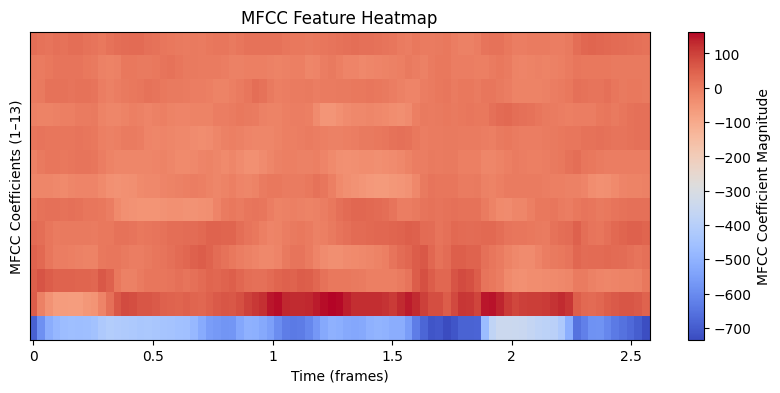

In [9]:
# Step 7: Visualize MFCC features as a heatmap

import librosa.display
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 4))

# Display MFCCs (like an image)
librosa.display.specshow(mfcc, sr=sr, x_axis='time')

# Add colorbar (to see intensity)
plt.colorbar(label='MFCC Coefficient Magnitude')

# Add title and labels
plt.title("MFCC Feature Heatmap")
plt.xlabel("Time (frames)")
plt.ylabel("MFCC Coefficients (1–13)")

# Show the plot
plt.show()


In [10]:
# Step 8: Loop through all .wav files and extract MFCC features for each one

import os
import numpy as np
import pandas as pd

# Dictionary to link folder name → label
label_map = {
    "depression1": "Depressed",
    "depression2": "Depressed",
    "normal1": "NotDepressed",
    "normal2": "NotDepressed"
}

# Lists to store features and their labels
features = []
labels = []
file_names = []

# Loop through each folder
for folder, label in label_map.items():
    folder_path = BASE / folder

    # Loop through every .wav file inside this folder
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            file_path = folder_path / file
            try:
                # 1️⃣ Load audio
                y, sr = librosa.load(file_path, sr=16000)

                # 2️⃣ Extract MFCCs
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                mfcc_mean = np.mean(mfcc, axis=1)   # mean across time

                # 3️⃣ Store the results
                features.append(mfcc_mean)
                labels.append(label)
                file_names.append(file)

            except Exception as e:
                print(f"Error processing {file}: {e}")

# Convert all to a DataFrame
df = pd.DataFrame(features, columns=[f"mfcc_{i}" for i in range(1, 14)])
df["label"] = labels
df["filename"] = file_names

# Show the first few rows
print("✅ Dataset created successfully!")
df.head()


✅ Dataset created successfully!


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label,filename
0,-530.644531,78.489700,18.757963,9.751894,21.164202,-0.453027,-16.253120,-11.114124,-0.743645,-5.589560,3.490472,-1.970267,13.371092,Depressed,OAF_back_sad.wav
1,-517.839722,82.785072,21.438154,5.768256,13.325665,1.231728,-13.277678,-13.804917,0.972705,-7.884349,2.277087,-1.916609,7.257521,Depressed,OAF_bar_sad.wav
2,-519.795227,71.355827,22.828283,18.992382,19.114937,-4.509700,-24.112745,-16.568436,2.123617,-10.486867,1.283807,-0.962527,5.633489,Depressed,OAF_base_sad.wav
3,-506.947235,85.372025,18.271324,11.123451,20.044744,1.155351,-11.044332,-12.069978,-1.654348,-1.459551,0.556750,-4.238388,7.102100,Depressed,OAF_bath_sad.wav
4,-537.116821,89.570488,32.787292,21.262123,15.631163,3.935444,-1.122711,-8.325363,-6.334487,-8.484164,-6.241811,-7.892676,1.673975,Depressed,OAF_bean_sad.wav


In [11]:
# Step 9: Inspect our prepared DataFrame (df)

# 1️⃣ Check how many rows and columns we have
print("Shape of df (rows, columns):", df.shape)

# 2️⃣ Display first few rows to get a sense of structure
print("\n🔹 Sample rows:")
display(df.head())

# 3️⃣ Check data types of each column
print("\n🔹 Column info:")
print(df.dtypes)

# 4️⃣ Count how many files belong to each label
print("\n🔹 Label distribution:")
print(df['label'].value_counts())

# 5️⃣ Quick descriptive statistics for numeric columns (mfccs)
print("\n🔹 Summary statistics:")
display(df.describe())


Shape of df (rows, columns): (800, 15)

🔹 Sample rows:


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,label,filename
0,-530.644531,78.489700,18.757963,9.751894,21.164202,-0.453027,-16.253120,-11.114124,-0.743645,-5.589560,3.490472,-1.970267,13.371092,Depressed,OAF_back_sad.wav
1,-517.839722,82.785072,21.438154,5.768256,13.325665,1.231728,-13.277678,-13.804917,0.972705,-7.884349,2.277087,-1.916609,7.257521,Depressed,OAF_bar_sad.wav
2,-519.795227,71.355827,22.828283,18.992382,19.114937,-4.509700,-24.112745,-16.568436,2.123617,-10.486867,1.283807,-0.962527,5.633489,Depressed,OAF_base_sad.wav
3,-506.947235,85.372025,18.271324,11.123451,20.044744,1.155351,-11.044332,-12.069978,-1.654348,-1.459551,0.556750,-4.238388,7.102100,Depressed,OAF_bath_sad.wav
4,-537.116821,89.570488,32.787292,21.262123,15.631163,3.935444,-1.122711,-8.325363,-6.334487,-8.484164,-6.241811,-7.892676,1.673975,Depressed,OAF_bean_sad.wav



🔹 Column info:
mfcc_1      float32
mfcc_2      float32
mfcc_3      float32
mfcc_4      float32
mfcc_5      float32
mfcc_6      float32
mfcc_7      float32
mfcc_8      float32
mfcc_9      float32
mfcc_10     float32
mfcc_11     float32
mfcc_12     float32
mfcc_13     float32
label        object
filename     object
dtype: object

🔹 Label distribution:
label
Depressed       400
NotDepressed    400
Name: count, dtype: int64

🔹 Summary statistics:


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,-448.164612,67.585220,17.132988,18.081833,2.099081,3.492659,-15.013476,-7.491122,-3.172168,-7.687727,0.199043,-1.264592,4.701190
std,64.879105,14.466640,12.421147,11.238636,12.717207,6.072478,5.236519,7.056561,5.811206,4.549521,4.940608,2.922652,2.794379
min,-572.609741,21.057430,-19.835682,-13.916399,-28.485708,-12.427296,-29.463028,-24.171230,-16.449125,-22.719330,-8.720795,-12.359288,-5.559339
25%,-508.410088,57.878536,8.581188,9.419212,-8.817779,-0.865576,-18.560727,-13.124835,-7.707847,-10.653466,-3.255706,-3.272300,2.882643
50%,-469.078918,67.857227,17.250873,17.857500,1.762732,3.062880,-14.956190,-8.700688,-3.951077,-7.193769,-0.983225,-1.078229,4.714680
75%,-385.766739,77.869427,26.399843,26.115714,13.463721,7.386122,-11.315417,-1.768653,1.512142,-4.281925,2.886351,0.726933,6.601060
max,-304.714020,116.333107,50.200394,47.054371,25.853559,21.586346,-1.122711,9.584265,11.430861,3.512679,17.181089,6.608049,13.371092


In [12]:
# Step 10: Split our DataFrame into X (features) and y (labels)

# 1️⃣ Drop non-numeric columns: 'label' and 'filename' → these are not features
X = df.drop(['label', 'filename'], axis=1)

# 2️⃣ Our target labels
y = df['label']

# 3️⃣ Check the shapes
print("Shape of X (features):", X.shape)
print("Shape of y (labels):", y.shape)

# 4️⃣ Preview
print("\n🔹 X sample:")
display(X.head())

print("\n🔹 y sample:")
print(y.head())


Shape of X (features): (800, 13)
Shape of y (labels): (800,)

🔹 X sample:


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,-530.644531,78.489700,18.757963,9.751894,21.164202,-0.453027,-16.253120,-11.114124,-0.743645,-5.589560,3.490472,-1.970267,13.371092
1,-517.839722,82.785072,21.438154,5.768256,13.325665,1.231728,-13.277678,-13.804917,0.972705,-7.884349,2.277087,-1.916609,7.257521
2,-519.795227,71.355827,22.828283,18.992382,19.114937,-4.509700,-24.112745,-16.568436,2.123617,-10.486867,1.283807,-0.962527,5.633489
3,-506.947235,85.372025,18.271324,11.123451,20.044744,1.155351,-11.044332,-12.069978,-1.654348,-1.459551,0.556750,-4.238388,7.102100
4,-537.116821,89.570488,32.787292,21.262123,15.631163,3.935444,-1.122711,-8.325363,-6.334487,-8.484164,-6.241811,-7.892676,1.673975



🔹 y sample:
0    Depressed
1    Depressed
2    Depressed
3    Depressed
4    Depressed
Name: label, dtype: object


In [13]:
# Step 10.1: Shuffle the DataFrame to remove any order bias

# We use sample(frac=1) to randomly shuffle all rows
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Let's verify the shuffle worked
print("✅ DataFrame shuffled successfully!")
print(df_shuffled.head())
print("\nLabel distribution after shuffle:")
print(df_shuffled['label'].value_counts())


✅ DataFrame shuffled successfully!
       mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5    mfcc_6  \
0 -490.705780   64.468491  -0.158466   3.391864  13.710093 -3.771521   
1 -534.231079   72.670227  10.759274   9.968804  10.715336  4.325977   
2 -487.884399  111.463585  27.351320   6.153672  -0.328845  0.631472   
3 -393.808960   50.296959  16.540960  37.734612  -5.655691  8.872957   
4 -495.462860   82.512108  24.922518  21.315384  11.608415  3.598439   

      mfcc_7     mfcc_8    mfcc_9    mfcc_10   mfcc_11   mfcc_12   mfcc_13  \
0 -11.438346 -10.096786 -6.187771   0.067756 -5.694637  0.574527  4.582752   
1  -5.384468  -6.940378 -9.529648  -3.922791 -3.838531 -0.173350  7.446109   
2  -8.050969 -11.392557 -6.866659  -4.800926 -6.493132 -6.019952  2.153066   
3 -11.518519  -8.544005  3.233514 -12.873621  8.259370 -3.717383  5.786826   
4  -9.649680  -7.045944 -6.194668  -5.629793 -4.154367 -5.341705  3.501964   

          label               filename  
0  NotDepressed  OAF_m

📘 Explanation:

sample(frac=1) → takes 100% of the rows (frac=1) but rearranges them randomly.

random_state=42 → ensures repeatability (same shuffle every time for consistency).

reset_index(drop=True) → resets index numbers (since after shuffle, old indexes are messy).

In [14]:
# Step 11: Split the shuffled dataset into training and testing sets

from sklearn.model_selection import train_test_split

# Features (X) and Labels (y) from the shuffled DataFrame
X = df_shuffled.drop(['label', 'filename'], axis=1)
y = df_shuffled['label']

# Split into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print the sizes
print("✅ Data split successful!")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Total features per sample: {X_train.shape[1]}")


✅ Data split successful!
Training samples: 640
Testing samples: 160
Total features per sample: 13


In [15]:
# Step 12: Train a Random Forest classifier on the training data

from sklearn.ensemble import RandomForestClassifier

# Create the model
rf_model = RandomForestClassifier(
    n_estimators=100,     # number of trees
    random_state=42,      # reproducibility
)

# Train (fit) the model
rf_model.fit(X_train, y_train)

print("✅ Model training complete!")


✅ Model training complete!


In [16]:
# Step 13: Evaluate model performance on the test set

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️⃣ Use the model to predict labels for the test data
y_pred = rf_model.predict(X_test)

# 2️⃣ Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# 3️⃣ Print results
print(f"✅ Model Accuracy: {accuracy*100:.2f}%\n")

print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 4️⃣ Confusion Matrix
print("🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


✅ Model Accuracy: 95.62%

🔹 Classification Report:
              precision    recall  f1-score   support

   Depressed       0.96      0.95      0.96        80
NotDepressed       0.95      0.96      0.96        80

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

🔹 Confusion Matrix:
[[76  4]
 [ 3 77]]


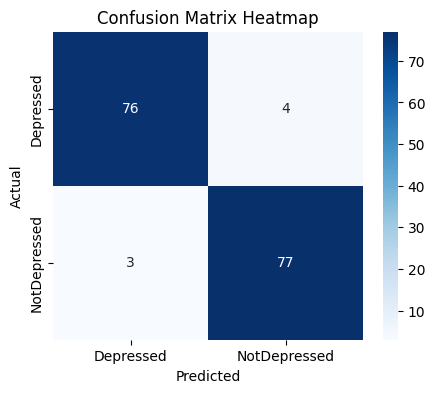

✅ Model saved successfully at: ../models/random_forest_audio_model.pkl


In [17]:
# Step 14: Visualize Confusion Matrix as a heatmap and save the trained model

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1️⃣ Confusion Matrix again
cm = confusion_matrix(y_test, y_pred)

# 2️⃣ Plot the heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Depressed','NotDepressed'], yticklabels=['Depressed','NotDepressed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# 3️⃣ Save the trained model for later use
model_path = "../models/random_forest_audio_model.pkl"
joblib.dump(rf_model, model_path)

print(f"✅ Model saved successfully at: {model_path}")


📘 Explanation (simple terms):

confusion_matrix again → numeric 2×2 table from last step.

sns.heatmap() → visualizes it (darker color = more predictions).

Top-left (TP): Correct Depressed

Bottom-right (TN): Correct NotDepressed

Off-diagonals: Wrong predictions

joblib.dump() → saves the model file so you can load it later (e.g., in Streamlit or Flask app).

In [19]:
# Step 15: Load the saved model and make prediction on a new audio file

import joblib
import numpy as np
import librosa

# 1️⃣ Load the trained model
model_path = "../models/random_forest_audio_model.pkl"
rf_loaded = joblib.load(model_path)
print("✅ Model loaded successfully!")

# 2️⃣ Pick a new audio file to test (you can replace the path)
new_audio_path = BASE / "depression1" / "OAF_back_sad.wav"   # change this file name to any real test file you have

# 3️⃣ Extract MFCC features for this new file (same process as training)
y_new, sr_new = librosa.load(new_audio_path, sr=16000)
mfcc_new = librosa.feature.mfcc(y=y_new, sr=sr_new, n_mfcc=13)
mfcc_mean_new = np.mean(mfcc_new, axis=1).reshape(1, -1)   # reshape for model input

# 4️⃣ Make prediction
prediction = rf_loaded.predict(mfcc_mean_new)[0]

print(f"🎯 Prediction for '{new_audio_path.name}' → {prediction}")


✅ Model loaded successfully!
🎯 Prediction for 'OAF_back_sad.wav' → Depressed


c:\Users\kushagra\Desktop\CSAI\Depression_Detection_Model\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


📘 Explanation (line by line):

joblib.load() → reloads your saved model file.

librosa.load() + feature.mfcc() → reuses the same feature extraction process for the new file (important: use same parameters).

.reshape(1, -1) → converts the MFCC array into a single row → model can read it.

predict() → the model outputs either "Depressed" or "NotDepressed" based on voice features.v